In [1]:
!pip install -Uqq fastbook

In [2]:
import fastbook
from fastbook import *
import fastai
from fastai.vision.all import *

import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path=Path()
path_project = Path('drive/MyDrive/Colab Notebooks/SpeeTorm')
path_data = path_project/'data'
path_model = path_project/'models'
path_predict = path_project/'predictions'

if not (path/'train').exists():
  !tar -xf drive/MyDrive/Colab\ Notebooks/SpeeTorm/data/re-train-images.tgz
if not (path/'test').exists():
  !tar -xf drive/MyDrive/Colab\ Notebooks/SpeeTorm/data/re-test-images.tgz

In [5]:
df_features_train = pd.read_csv(path_data/'training_set_features.csv')
df_labels_train = pd.read_csv(path_data/'training_set_labels.csv')

df = df_features_train.merge(df_labels_train, how='right', on='image_id')
df.head()

,image_id,storm_id,relative_time,ocean,wind_speed
0,abs_000,abs,0,2,43
1,abs_001,abs,1800,2,44
2,abs_002,abs,5400,2,45
3,abs_003,abs,17999,2,52
4,abs_004,abs,19799,2,53


In [6]:
def get_x(r): return path/'train'/f"{r['image_id']}.jpg"
def get_y(r): return r['wind_speed']

def splitter(r, pct=0.8):
  train = df.index[:int(pct*len(df))].tolist()
  valid = df.index[int(pct*len(df)):].tolist()
  return train, valid

def get_dls(r, bs, aug=None):
  dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                     get_x=get_x,
                     get_y=get_y,
                     splitter=splitter,
                     #item_tfms=Resize(460),
                     batch_tfms=aug)
  return dblock.dataloaders(r, bs=bs, shuffle_train=True)

In [7]:
def get_tstamp():
  tz = timezone('Australia/Melbourne')
  return datetime.now(tz=tz).strftime("%d-%m-%Y %H:%M %p")

def save_model(learner, path, name='SpeeTorm_Mod'):
  if not path.exists():
    path.mkdir()

  learner.export(path/f'{name}_{get_tstamp()}.pkl')

def save_prediction(df, path, name='SpeeTorm_Pred'):
  if not path.exists():
    path.mkdir()

  df.to_csv(path/f'{name}_{get_tstamp()}.csv',
            columns=['image_id', 'wind_speed'],
            index=False)
  
def get_predictions(df, model):
  test_imgs = [f"test/{x}.jpg" for x in df.image_id]

  test_dls = model.dls.test_dl(test_imgs, bs=256)
  return model.get_preds(dl=test_dls)

def add_predictions(df, result, cat=None):
  
  if not df.columns[-1] == 'wind_speed':
    df['wind_speed'] = 0

  if not cat:
    df['wind_speed'] = [int(x) for item in result[0] for x in item]
  elif cat == 1:
    df.loc[df.ocean==1, 'wind_speed'] = [int(x) for item in result[0] for x in item]
  elif cat == 2:
    df.loc[df.ocean==2, 'wind_speed'] = [int(x) for item in result[0] for x in item]
  
  return df

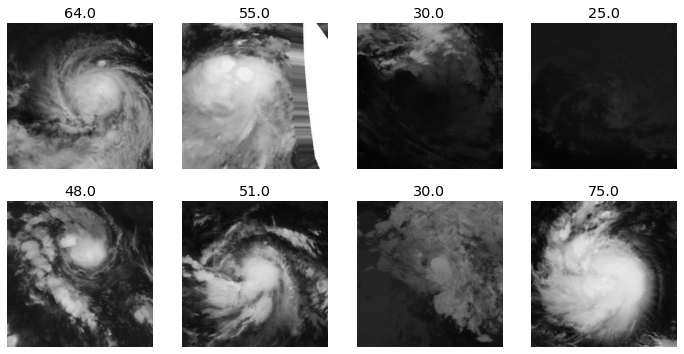

In [8]:
aug = aug_transforms()

dls = get_dls(df, 128, aug=aug)
dls.train.show_batch(max_n=8, nrows=2, unique=False)

In [9]:
model = xresnet18()

learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse)

In [10]:
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,_rmse,time


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:995: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


RuntimeError: ignored